In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import PIL
import pickle
from PIL import *
import cv2
import tensorflow as tf
import keras
from keras.applications import DenseNet121 # 2017 architecture
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from keras import *
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, optimizers
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# RESBLOCK :=> input -> Convolution Block -> Identity Block -> Identity Block -> output
def res_block(X, filters,stage):
    # Convolution Block
    X_copy = X

    f1, f2, f3 = filters

    # Main path
    X = Conv2D(f1,(1,1), strides = (1,1), name = 'res_'+str(stage)+'_conv_a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_conv_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2,(3,3), strides = (1,1), padding= 'same', name = 'res_' + str(stage) + '_conv_b', kernel_initializer = glorot_uniform(seed = 0))(X)

    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_conv_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3,(1,1),strides = (1,1), name ='res_' + str(stage) + '_conv_c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_conv_c')(X)

    # Short path

    X_copy = Conv2D(f3,(1,1), strides =(1,1), name = 'res_'+str(stage) +'_conv_copy', kernel_initializer = glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis = 3, name='bn_'+str(stage)+'_conv_copy')(X_copy)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity BLock 1
    X_copy = X

    # main path

    X = Conv2D(f1,(1,1), strides = (1,1), name = 'res_'+str(stage)+'_identity_1_a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_identity_1_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2,(3,3), strides = (1,1), padding= 'same', name = 'res_' + str(stage) + '_identity_1_b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_identity_1_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, (1,1),strides = (1,1), name ='res_' + str(stage) + '_identity_1_c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_identity_1_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # identity block 2
    X_copy = X

    # main path
    X = Conv2D(f1,(1,1), strides = (1,1), name = 'res_'+str(stage)+'_identity_2_a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_identity_2_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2,(3,3), strides = (1,1), padding= 'same', name = 'res_' + str(stage) + '_identity_2_b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_identity_2_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, (1,1),strides = (1,1), name ='res_' + str(stage) + '_identity_2_c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+ str(stage) + '_identity_2_c')(X)
    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
facialexpression_df = pd.read_csv('/content/drive/MyDrive/DL Facial Recognition /icml_face_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
facialexpression_df = facialexpression_df.drop(columns = " Usage")


In [ ]:
facialexpression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
def string2array(x):
    return np.array(x.split(' ')).reshape(48,48,1).astype('float32')

In [ ]:
def resize(x):
    img = x.reshape(48,48)
    return cv2.resize(img, dsize=(96,96), interpolation = cv2.INTER_CUBIC)

In [ ]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x : string2array(x))
facialexpression_df[' pixels'] =  facialexpression_df[' pixels'].apply(lambda x : resize(x))

In [ ]:
facialexpression_df.shape

(35887, 2)

In [ ]:
label_to_text = {0: 'anger', 1 : 'disgust', 2 : 'fear', 3 : 'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

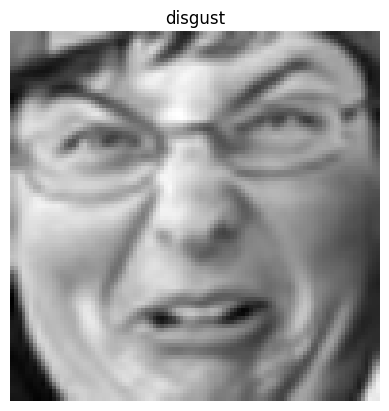

In [ ]:
emotions = [1]
for i in emotions:
    data = facialexpression_df[facialexpression_df['emotion']==i][:1]

    img = data[' pixels'].item()
    img = img.reshape(96, 96)

    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')

In [ ]:
facialexpression_df.emotion.value_counts().index

Index([3, 6, 4, 2, 0, 5, 1], dtype='int64', name='emotion')

In [ ]:
facialexpression_df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [ ]:
class1 = facialexpression_df.loc[facialexpression_df['emotion'] == 1]
class1.shape

(547, 2)

In [ ]:
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(35887,96,96,1)

print(X.shape, y.shape)

(35887, 96, 96, 1) (35887, 7)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32298, 96, 96, 1), (1795, 96, 96, 1), (32298, 7), (1795, 7))

In [ ]:
X_train = X_train/255
X_val   = X_val /255
X_test  = X_test/255

In [ ]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [2]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(7, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

facialmodel = Model(inputs= X_input, outputs = X, name = 'Resnet18')

facialmodel.summary()

NameError: name 'Input' is not defined

In [ ]:
facialmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "/content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [ ]:
history = facialmodel.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data= (X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 100, callbacks=[checkpointer, earlystopping])

Epoch 1/100
504/504 [==============================] - ETA: 0s - loss: 1.6467 - accuracy: 0.3616
Epoch 1: val_loss improved from inf to 1.62009, saving model to /content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 61s 85ms/step - loss: 1.6467 - accuracy: 0.3616 - val_loss: 1.6201 - val_accuracy: 0.3645
Epoch 2/100
504/504 [==============================] - ETA: 0s - loss: 1.3345 - accuracy: 0.4878
Epoch 2: val_loss did not improve from 1.62009
504/504 [==============================] - 39s 78ms/step - loss: 1.3345 - accuracy: 0.4878 - val_loss: 1.7552 - val_accuracy: 0.2759
Epoch 3/100
504/504 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.5312
Epoch 3: val_loss improved from 1.62009 to 1.48953, saving model to /content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights.hdf5
504/504 [==============================] - 39s 77ms/step - loss: 1.2314 - accuracy: 0.5312 - val_loss: 1.4895 - val_accuracy: 0.3857
Epoch 4/100
504/504 [==============================] - ETA: 0s - loss: 1.1684 - accuracy: 0.5580
Epoch 4: val_loss improved from 1.48953 to 1.27743, saving model to /content/drive/MyDrive/DL Facial Recognition /Facia

In [ ]:
score = facialmodel.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

57/57 [==============================] - 1s 13ms/step - loss: 1.1341 - accuracy: 0.6373
Test Accuracy: 0.6373258829116821


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

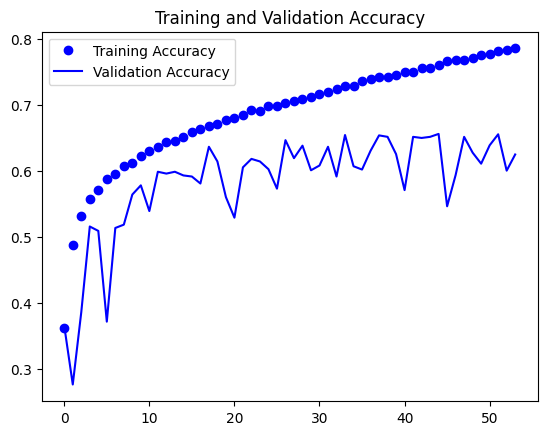

In [ ]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

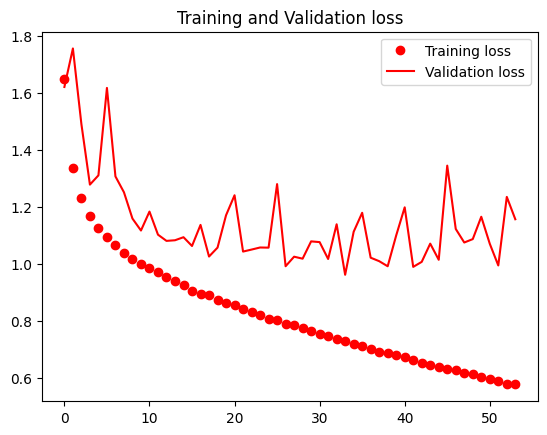

In [ ]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [ ]:
predicted_classes = np.argmax(facialmodel.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

57/57 [==============================] - 1s 5ms/step


<Axes: >

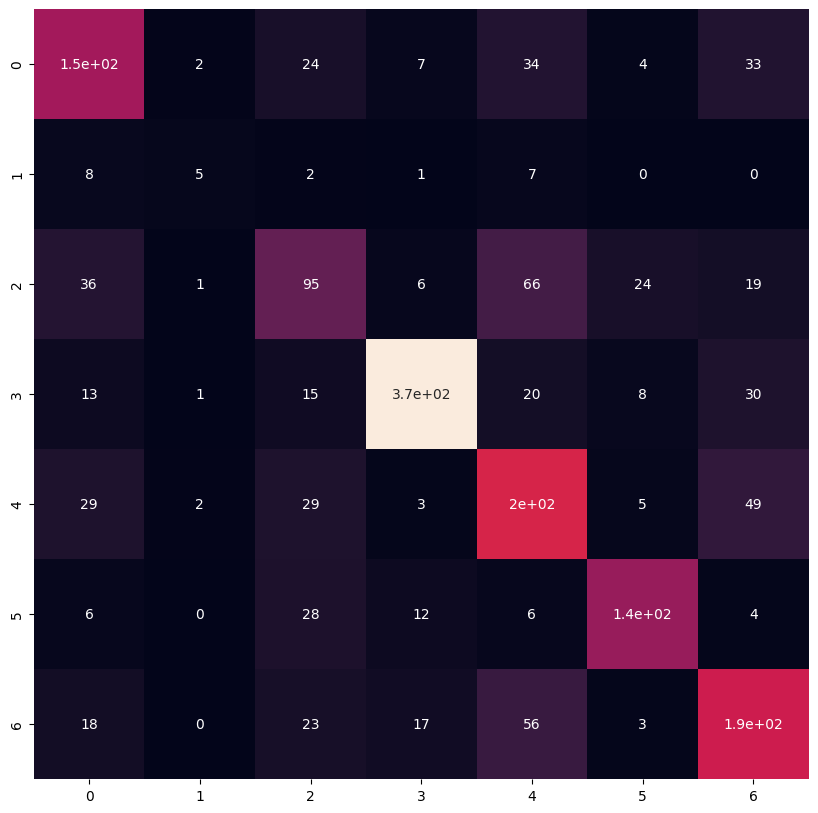

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

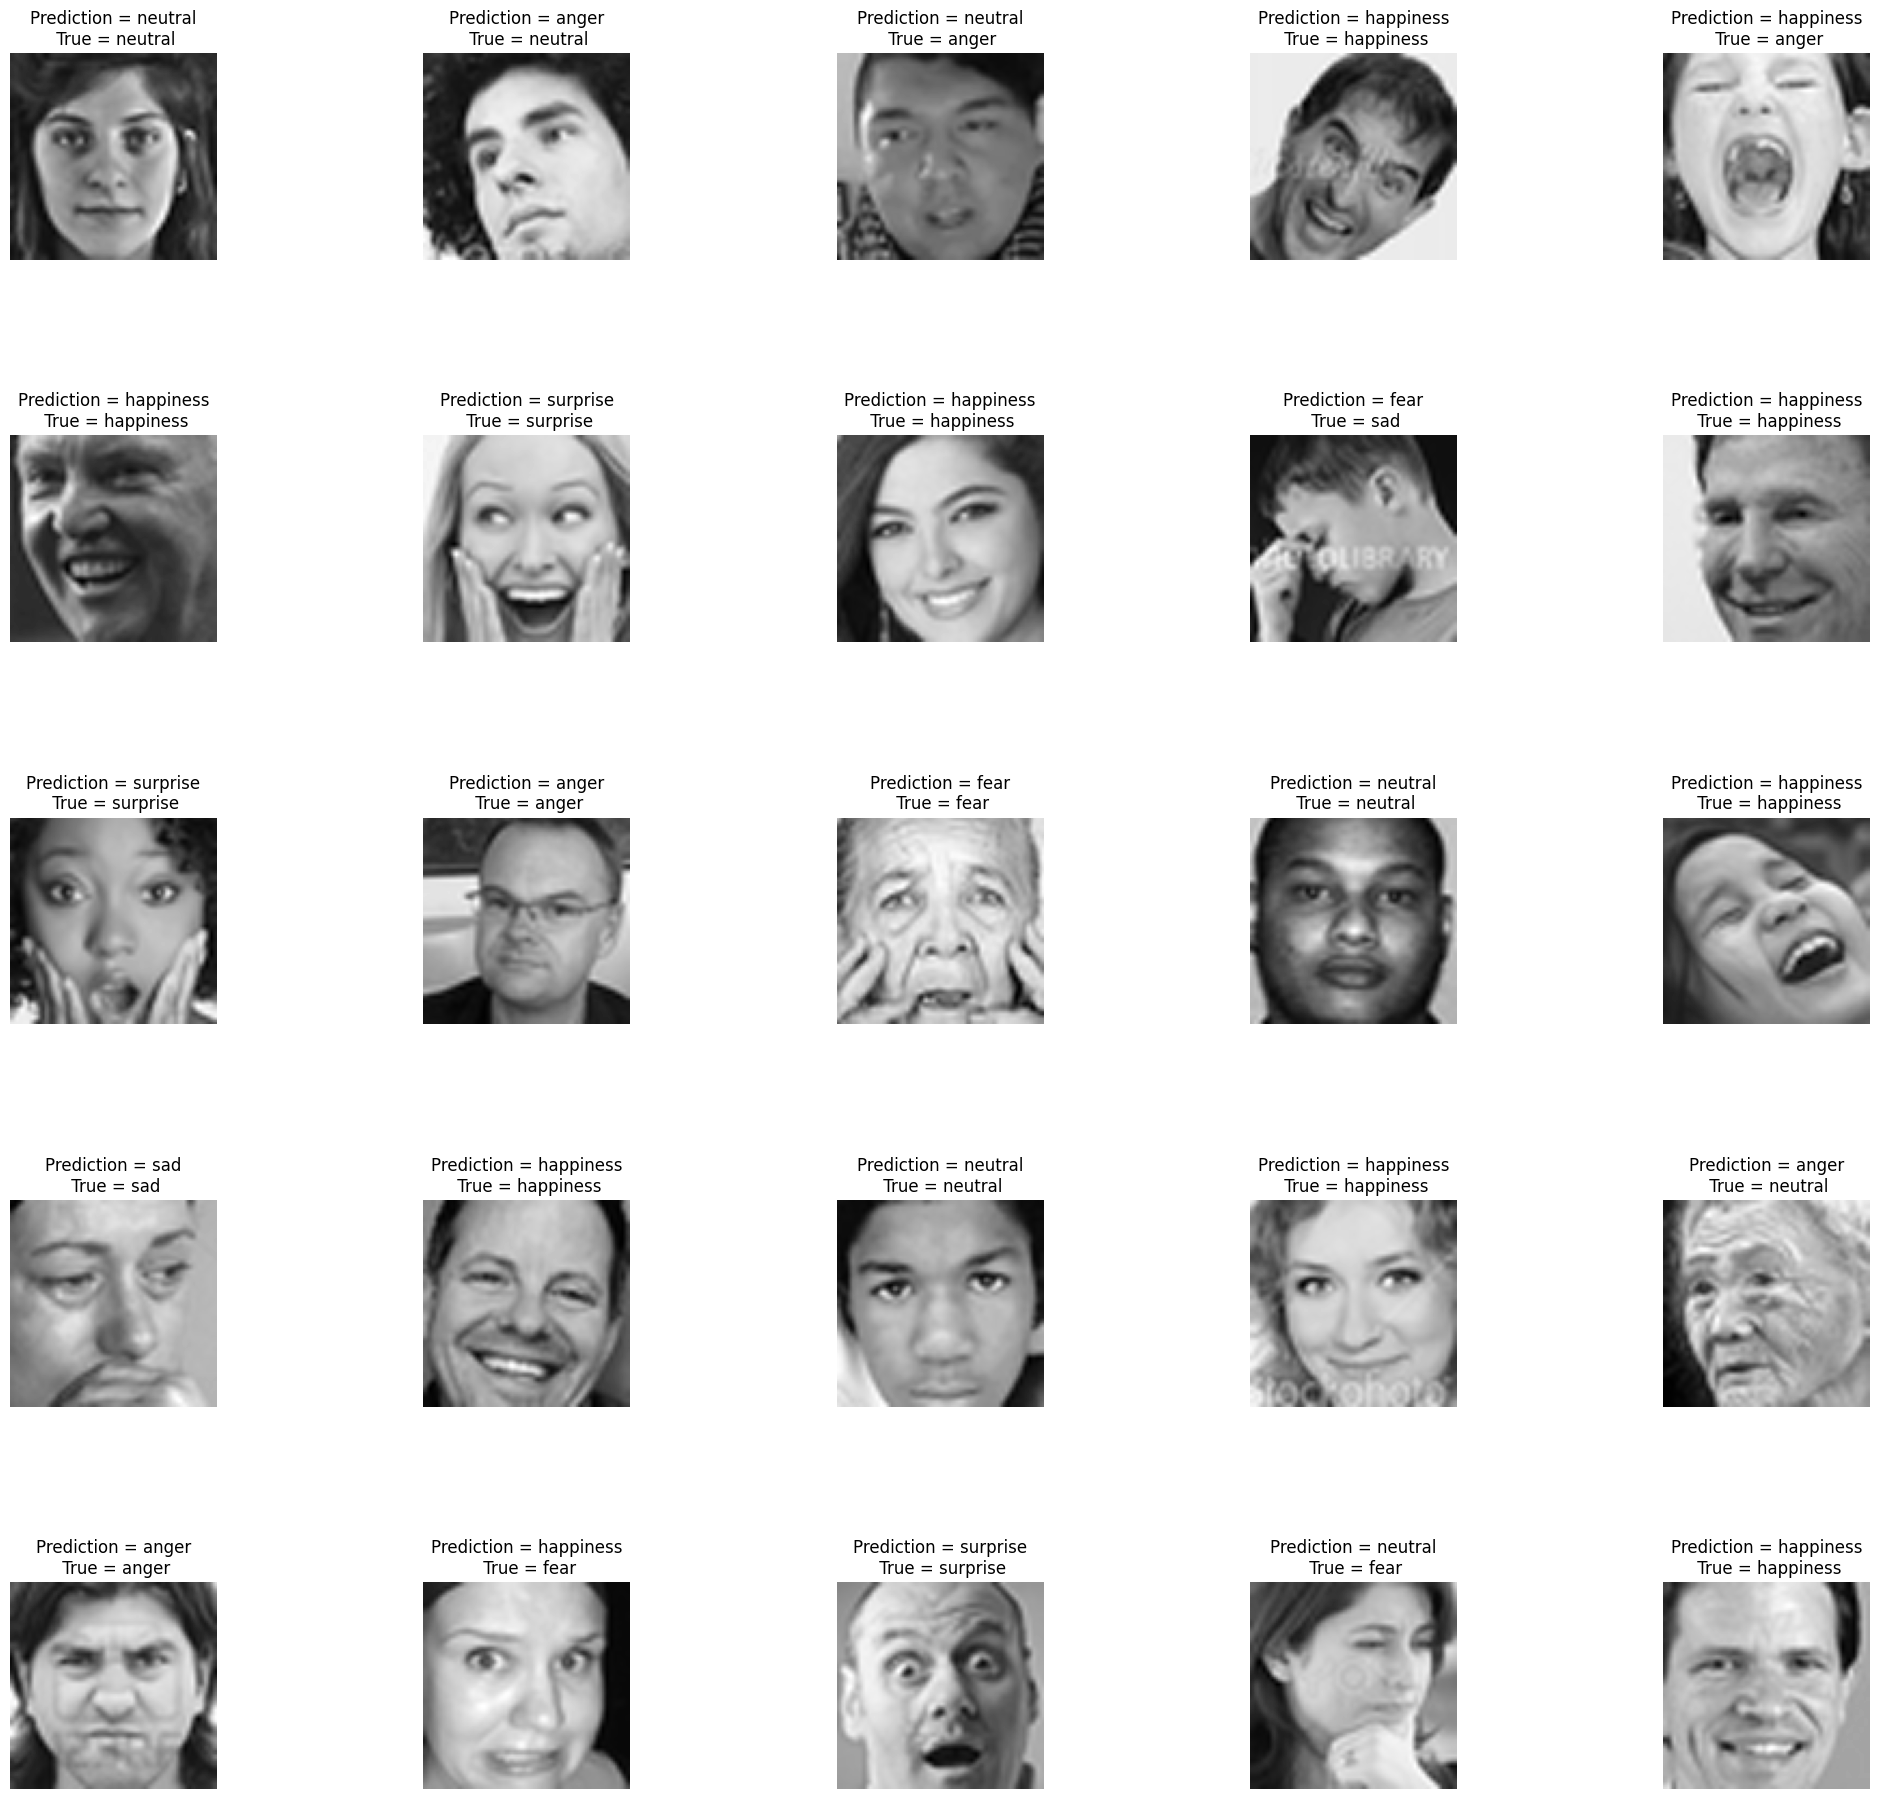

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [ ]:
# Compute accuracy
accuracy = np.mean(predicted_classes == y_true)

print("Accuracy:", accuracy)

Accuracy: 0.6373259052924791


In [ ]:
from keras.applications import VGG16
def VGG16_grayscale(input_shape=(96, 96, 1), num_classes=7):
    # Define input tensor shape
    X_input = Input(shape=input_shape)

    # Block 1
    X = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(X_input)
    X = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(X)

    # Block 2
    X = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(X)
    X = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(X)

    # Block 3
    X = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(X)
    X = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(X)
    X = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(X)

    # Block 4
    X = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(X)
    X = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(X)
    X = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(X)

    # Block 5
    X = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(X)
    X = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(X)
    X = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(X)

    # Classification block
    X = Flatten(name='flatten')(X)
    X = Dense(4096, activation='relu', name='fc1')(X)
    X = Dense(4096, activation='relu', name='fc2')(X)
    output = Dense(num_classes, activation='softmax', name='predictions')(X)

    # Create model
    model = Model(inputs=X_input, outputs=output, name='vgg16')

    return model

# Create VGG16 model for grayscale images
facial_model = VGG16_grayscale(input_shape=(96, 96, 1), num_classes=7)

# Print model summary
facial_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [ ]:


# Compile the model
facial_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "/content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights_VGG.hdf5", verbose = 1, save_best_only=True)

In [ ]:
history = facial_model.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data= (X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 100, callbacks=[checkpointer, earlystopping])

Epoch 1/100
504/504 [==============================] - ETA: 0s - loss: 1.8126 - accuracy: 0.2502
Epoch 1: val_loss improved from inf to 1.80977, saving model to /content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights_VGG.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 109s 216ms/step - loss: 1.8126 - accuracy: 0.2502 - val_loss: 1.8098 - val_accuracy: 0.2508
Epoch 2/100
504/504 [==============================] - ETA: 0s - loss: 1.8120 - accuracy: 0.2504
Epoch 2: val_loss did not improve from 1.80977
504/504 [==============================] - 83s 165ms/step - loss: 1.8120 - accuracy: 0.2504 - val_loss: 1.8102 - val_accuracy: 0.2508
Epoch 3/100
504/504 [==============================] - ETA: 0s - loss: 1.8120 - accuracy: 0.2504
Epoch 3: val_loss improved from 1.80977 to 1.80967, saving model to /content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights_VGG.hdf5
504/504 [==============================] - 135s 268ms/step - loss: 1.8120 - accuracy: 0.2504 - val_loss: 1.8097 - val_accuracy: 0.2508
Epoch 4/100
504/504 [==============================] - ETA: 0s - loss: 1.8121 - accuracy: 0.2501
Epoch 4: val_loss improved from 1.80967 to 1.80957, saving model to /content/drive/MyDrive/DL Facial Recogniti

In [ ]:
score = facial_model.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [ ]:
predicted_classes = np.argmax(facial_model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)